$$\rho \left( \frac{\partial u}{\partial t} + u \cdot \nabla u \right) = \nabla \cdot \sigma (u,p)+f$$
$$\nabla \cdot u = 0$$

$$ \sigma (u,p) = 2 \mu \epsilon(u)-p I$$

$$\epsilon(u) = \frac{1}{2} (\nabla u + (\nabla u)^T)$$




In [1]:
from mpi4py import MPI
from dolfinx import mesh
import ufl
import numpy as np
from dolfinx import fem

class BoundaryCondition():
    def __init__(self, type, marker, values,facet_tag, functionspace,ds=None):
        self._type = type
        if type == "Dirichlet":
            if callable(values):
                u_D = fem.Function(functionspace)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(u_D, dofs)
            else:
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(values, dofs,functionspace) #wall_dofs, V)
        elif type == "Neumann":
                self._bc = ufl.inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * ufl.inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

In [2]:
import numpy as np
from dolfinx import fem
from dolfinx import mesh
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element



## For this problem

$$\rho \left( \frac{\partial u}{\partial t} + u \cdot \nabla u \right) = \nabla \cdot ( \mu (\nabla u + (\nabla u)^T) -p I) +f$$

$$\rho \left( \frac{\partial u}{\partial t} + u \cdot \nabla u \right) = \mu \nabla^2 u -p I +f$$

$$\nabla \cdot u = 0$$


## This is

$$  ( \frac{\partial u}{\partial t} + ( u_x \partial_x u_x + u_y \partial_y u_y + u_z \partial_z u_z ) ) = \frac{\mu}{\rho} ( ( \partial_x^2 u_x + \partial_y^2 u_y +  \partial_z^2 u_z  ) - ( \partial_x p + \partial_y p + \partial_z p ) ) + f $$

In [4]:
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 10, 10, 10)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

t = 0
T = 10
num_steps = 500

dt = T / num_steps

#Elements
v_cg2 = element("Lagrange", domain.topology.cell_name(), 2, shape=(domain.geometry.dim, ))
s_cg1 = element("Lagrange", domain.topology.cell_name(), 1)
V = fem.functionspace(domain, v_cg2)
Q = fem.functionspace(domain, s_cg1)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
p = ufl.TrialFunction(Q)
q = ufl.TestFunction(Q)

#Boundaries
boundaries=[
    (1, lambda x: np.isclose(x[0],0)), # x=0
    (2, lambda x: np.isclose(x[0],1)), # x=1
    (3, lambda x: np.isclose(x[1],0)), # y=0
    (4, lambda x: np.isclose(x[1],1)), # y=1
    (5, lambda x: np.isclose(x[2],0)), # z=0
    (6, lambda x: np.isclose(x[2],1)) # z=1
]

facet_indices,facet_markers=[],[]
for (marker, locator) in boundaries:
    facets= mesh.locate_entities(domain,fdim,locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets,marker))
facet_indices=np.hstack(facet_indices).astype(np.int32)
facet_markers=np.hstack(facet_markers).astype(np.int32)
sorted_facets=np.argsort(facet_indices)
facet_tag=mesh.meshtags(domain,fdim,facet_indices[sorted_facets],facet_markers[sorted_facets])

u_noslip = np.array((0,) * domain.geometry.dim, dtype=PETSc.ScalarType)
#bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)
#bc_inflow = dirichletbc(PETSc.ScalarType(0), inflow_dofs, Q)

velocity_boundary_conditions = [
    BoundaryCondition("Dirichlet", 3,u_noslip,facet_tag,V)._bc,
    #fem.dirichletbc(u_noslip, inflow_dofs, V),
    BoundaryCondition("Dirichlet", 4, u_noslip,facet_tag,V)._bc,
    BoundaryCondition("Dirichlet", 5, u_noslip,facet_tag,V)._bc,
    BoundaryCondition("Dirichlet", 6, u_noslip,facet_tag,V)._bc,
]

pressure_boundary_conditions=[
    BoundaryCondition("Dirichlet", 1, PETSc.ScalarType(8),facet_tag,Q)._bc,
    #fem.dirichletbc(PETSc.ScalarType(0), inflow_dofs, Q),
    BoundaryCondition("Dirichlet", 2, PETSc.ScalarType(0),facet_tag,Q)._bc
    #fem.dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q),
                      ]

In [7]:
u_n = fem.Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = ufl.FacetNormal(domain)
f = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))
k = fem.Constant(domain, PETSc.ScalarType(dt))
mu = fem.Constant(domain, PETSc.ScalarType(1))
rho = fem.Constant(domain, PETSc.ScalarType(1))

In [8]:
import dolfinx.fem.petsc

# Define strain-rate tensor
def epsilon(u):
    return ufl.sym(ufl.nabla_grad(u))

# Define stress tensor


def sigma(u, p):
    return 2 * mu * epsilon(u) - p * ufl.Identity(len(u))


# Define the variational problem for the first step
p_n = dolfinx.fem.Function(Q)
p_n.name = "p_n"
F1 = rho * ufl.dot((u - u_n) / k, v) * ufl.dx
F1 += rho * ufl.dot(ufl.dot(u_n, ufl.nabla_grad(u_n)), v) * ufl.dx
F1 += ufl.inner(sigma(U, p_n), epsilon(v)) * ufl.dx
F1 += ufl.dot(p_n * n, v) * ufl.ds - ufl.dot(mu * ufl.nabla_grad(U) * n, v) * ufl.ds
F1 -= ufl.dot(f, v) * ufl.dx
a1 = fem.form(ufl.lhs(F1))
L1 = fem.form(ufl.rhs(F1))
import dolfinx.fem.petsc
A1 = fem.petsc.assemble_matrix(a1, bcs=velocity_boundary_conditions)
A1.assemble()
b1 = fem.petsc.create_vector(L1)

# Define variational problem for step 2
u_ = dolfinx.fem.Function(V)
a2 = fem.form(ufl.dot(ufl.nabla_grad(p), ufl.nabla_grad(q)) * ufl.dx)
L2 = fem.form(ufl.dot(ufl.nabla_grad(p_n), ufl.nabla_grad(q)) * ufl.dx - (rho / k) * ufl.div(u_) * q * ufl.dx)
A2 = fem.petsc.assemble_matrix(a2, bcs=pressure_boundary_conditions)
A2.assemble()
b2 = fem.petsc.create_vector(L2)

# Define variational problem for step 3
p_ = dolfinx.fem.Function(Q)
a3 = fem.form(rho * ufl.dot(u, v) * ufl.dx)
L3 = fem.form(rho * ufl.dot(u_, v) * ufl.dx - k * ufl.dot(ufl.nabla_grad(p_ - p_n), v) * ufl.dx)
A3 = fem.petsc.assemble_matrix(a3)
A3.assemble()
b3 = fem.petsc.create_vector(L3)

In [9]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(domain.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(domain.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)


In [10]:
from dolfinx.io import VTXWriter
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(domain.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(domain.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

In [13]:
def u_exact(x):
    values = np.zeros((3, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1]) + 4 * x[2] * (1.0 - x[2])
    return values


u_ex = fem.Function(V)
u_ex.interpolate(u_exact)

L2_error = fem.form(ufl.dot(u_ - u_ex, u_ - u_ex) * ufl.dx)

In [15]:
Pv=[]
Vv=[]
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    dolfinx.fem.petsc.assemble_vector(b1, L1)
    dolfinx.fem.petsc.apply_lifting(b1, [a1], [velocity_boundary_conditions])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.petsc.set_bc(b1, velocity_boundary_conditions)
    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    dolfinx.fem.petsc.assemble_vector(b2, L2)
    dolfinx.fem.petsc.apply_lifting(b2, [a2], [pressure_boundary_conditions])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.petsc.set_bc(b2, pressure_boundary_conditions)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    dolfinx.fem.petsc.assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]
    Pv.append(p_n.eval(domain.geometry.x,np.arange(int(11**3))))
    Vv.append(u_n.eval(domain.geometry.x,np.arange(int(11**3))))

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(L2_error), op=MPI.SUM))
    error_max = domain.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.04, L2-error 1.18e+00, Max error 5.14e-04
Time 0.44, L2-error 1.08e+00, Max error 1.82e-04
Time 0.84, L2-error 1.08e+00, Max error 1.15e-04
Time 1.24, L2-error 1.08e+00, Max error 1.41e-04
Time 1.64, L2-error 1.08e+00, Max error 1.58e-04
Time 2.04, L2-error 1.08e+00, Max error 1.69e-04
Time 2.44, L2-error 1.08e+00, Max error 1.76e-04
Time 2.84, L2-error 1.08e+00, Max error 1.82e-04
Time 3.24, L2-error 1.08e+00, Max error 1.86e-04
Time 3.64, L2-error 1.08e+00, Max error 1.89e-04
Time 4.04, L2-error 1.08e+00, Max error 1.91e-04
Time 4.44, L2-error 1.08e+00, Max error 1.93e-04
Time 4.84, L2-error 1.08e+00, Max error 1.94e-04
Time 5.24, L2-error 1.08e+00, Max error 1.96e-04
Time 5.64, L2-error 1.08e+00, Max error 1.97e-04
Time 6.04, L2-error 1.08e+00, Max error 1.98e-04
Time 6.44, L2-error 1.08e+00, Max error 1.98e-04
Time 6.84, L2-error 1.08e+00, Max error 1.99e-04
Time 7.24, L2-error 1.08e+00, Max error 1.99e-04
Time 7.64, L2-error 1.08e+00, Max error 2.00e-04
Time 8.04, L2-error 

# Creation of pandas dataset

In [30]:
import pandas as pd
import os
from einops import repeat,rearrange

def solution_data_normalization(U,P,X,delta_t):
    Uv_=np.concatenate([Vv_,Pv_],axis=-1)
    X=repeat(domain.geometry.x[:,:],"p v -> t p v",t=500)
    T=repeat(np.array([dt*t for t in range(1,501)]),"t -> t p 1",p=int(11**3))
    XT=np.concatenate([X,T],axis=-1)
    Uv_=rearrange(Uv_,"t p v -> (t p) v")
    XT=rearrange(XT,"t p v -> (t p) v")

    data_dict={
        "u":Uv_[:,0].tolist(),
        "v":Uv_[:,1].tolist(),
        "w":Uv_[:,2].tolist(),
        "p":Uv_[:,3].tolist(),
        "x":XT[:,0].tolist(),
        "y":XT[:,1].tolist(),
        "z":XT[:,2].tolist(),
        "t":XT[:,3].tolist()
    }
    return pd.DataFrame(data_dict)
Vv_=np.array(Vv)
Pv_=np.array(Pv)

In [31]:

solution_data_normalization(Vv_,Pv_,domain.geometry.x,dt)

,u,v,w,p,x,y,z,t
0,-0.000077,-0.000011,-0.000011,7.997253e-01,0.9,0.0,0.0,0.02
1,-0.000155,0.000048,0.000048,-1.520751e-17,1.0,0.0,0.0,0.02
2,-0.000116,0.000032,-0.000010,-7.432347e-17,1.0,0.1,0.0,0.02
3,0.142633,0.000209,0.000209,2.748831e-15,1.0,0.1,0.1,0.02
4,0.052734,0.001262,0.001210,-7.803089e-16,1.0,0.0,0.1,0.02
...,...,...,...,...,...,...,...,...
665495,-0.013762,0.000761,0.000603,7.998715e+00,0.0,1.0,0.8,10.00
665496,-0.114517,0.000644,0.000645,7.199223e+00,0.1,1.0,1.0,10.00
665497,0.235668,-0.000099,-0.000019,7.999284e+00,0.0,1.0,0.9,10.00
665498,0.612653,0.001205,0.001340,7.999557e+00,0.0,0.9,1.0,10.00


In [32]:
#domain.geometry.x[:,0]
dd=solution_data_normalization(Vv_,Pv_,domain.geometry.x,dt)
ROOT="/app/Exploring_repo/"
dd.to_csv(os.path.join(ROOT,"Data/3D_NS_eq_Dirichlet_Linear_Linear_f_zero_S10x10_T10_500.csv"))

trame


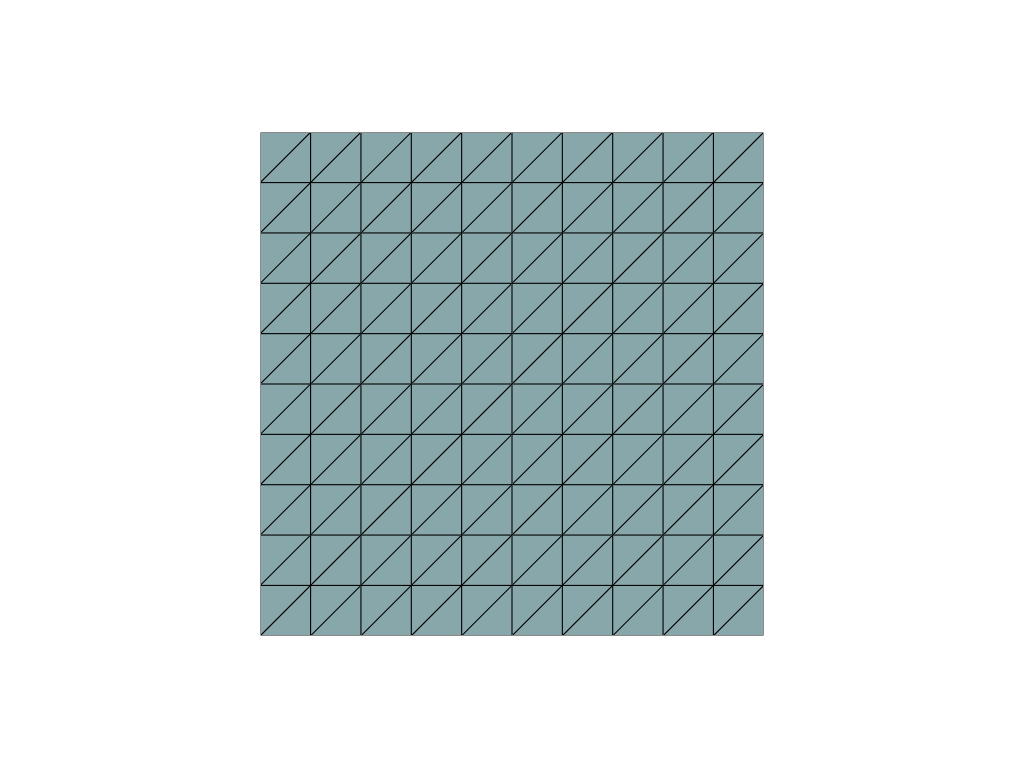

2025-06-25 17:01:42.605 (   5.069s) [    764879E20000]vtkDataSetAttributes.cx:1576  WARN| vtkPointData (0x59d88a0e0ad0): Can not set attribute Vectors. Incorrect number of components.


ValueError: Data field (P) with type (FieldAssociation.POINT) could not be set as the active vectors

In [16]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
P=Vv[-1]
P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid["P"]=P_
u_grid.set_active_vectors("P")

p = pyvista.Plotter()
p.add_mesh(u_grid.arrows, line_width=0.5,lighting=False,opacity=0.9, scalar_bar_args={"title": "Q"})
p.add_mesh(u_grid, color="grey", ambient=0.6, opacity=0.6, show_edges=False)
_ = p.add_axes(line_width=5, labels_off=True)
p.view_xy()

p.show()

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


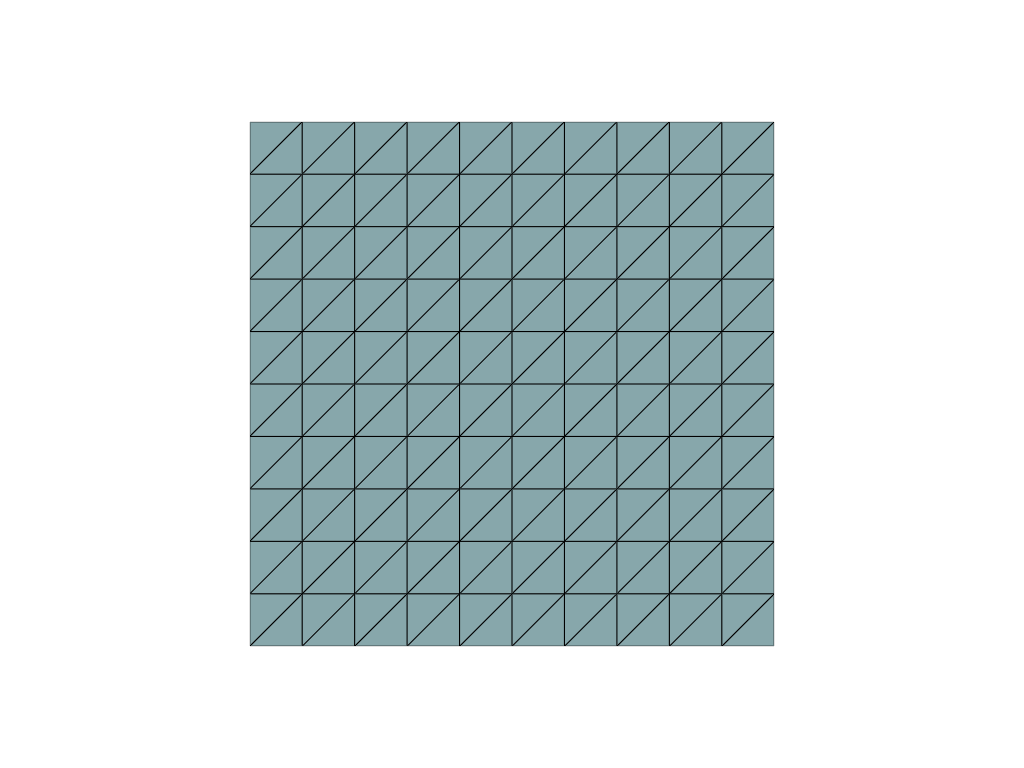

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


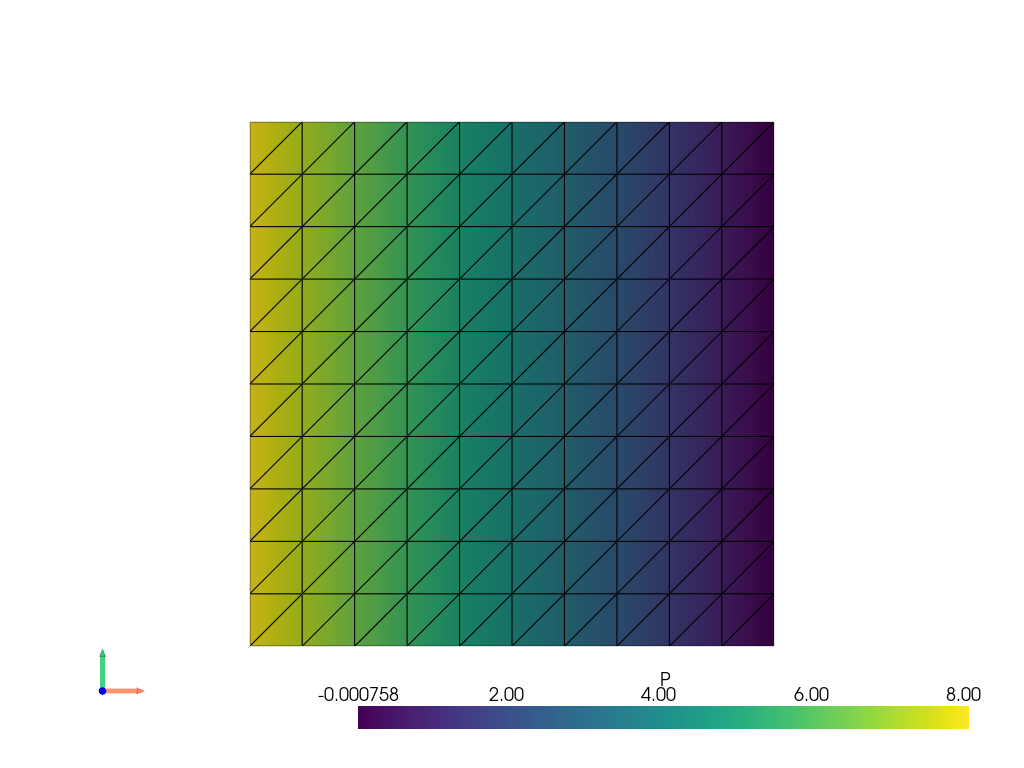

In [ ]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
#P=Pv[-1]
#P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid.point_data["P"]=Pv[2]
u_grid.set_active_scalars("P")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.add_axes(line_width=5, labels_off=True)
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [ ]:
#Vv[0].x.array.shape
Vv[0].evaluate?

Signature: Vv[0].evaluate(x, mapping, component, index_values, derivatives=())
Docstring: Get *self* from *mapping* and return the component asked for.
File:      /dolfinx-env/lib/python3.12/site-packages/ufl/core/terminal.py
Type:      method